# 网络中的网络（NiN）
LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。

AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。 或者，可以想象在这个过程的早期使用全连接层。

然而，如果使用了全连接层，可能会完全放弃表征的空间结构而且。

网络中的网络（NiN）提供了一个非常简单的解决方案：**在每个像素的通道上分别使用多层感知机**。

## 7.3.1. NiN块
卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。 全连接层的输入和输出通常是分别对应于样本和特征的二维张量。

NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。 如果我们将权重连接到每个空间位置，我们可以将其视为1x1卷积层（如 6.4节中所述），或作为在每个像素位置上独立作用的全连接层。 从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。

![](../img/7_4.png)

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels,out_channels,kernel_size,strides,padding):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding),  # 卷积层
        nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),
        nn.ReLU(),  # 1X1卷积层
        nn.Conv2d(out_channels,out_channels,kernel_size=1),
        nn.ReLU()  # 1X1卷积层
    )


## 7.3.2. NiN模型
最初的NiN网络是在AlexNet后不久提出的，显然从中得到了一些启示。NiN使用窗口形状为$11\times 11$、$5\times 5$和$3\times 3$的卷积层，输出通道数量与AlexNet中的相同。每个NiN块后有一个最大汇聚层，汇聚窗口形状为$3\times 3$，步幅为2。

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。相反，NiN使用一个NiN块，其输出通道数等于标签类别的数量。最后放一个*全局平均汇聚层*（global average pooling layer），生成一个对数几率	（logits）。NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。

In [2]:
net=nn.Sequential(
    nin_block(in_channels=1,out_channels=96,kernel_size=11,strides=4,padding=0),
    nn.MaxPool2d(kernel_size=3,stride=2),

    nin_block(in_channels=96,out_channels=256,kernel_size=5,strides=1,padding=2),
    nn.MaxPool2d(kernel_size=3,stride=2),

    nin_block(in_channels=256,out_channels=384,kernel_size=3,strides=1,padding=1),
    nn.MaxPool2d(kernel_size=3,stride=2),

    nn.Dropout(p=0.5),

    # 标签类别数是10
    nin_block(in_channels=384,out_channels=10,kernel_size=3,strides=1,padding=1),
    nn.AdaptiveAvgPool2d((1,1)),

    # 将四维的输出转为二维的输出，其形状为（批量大小，10）
    nn.Flatten()
)

# 创建一个数据样本来查看每个块的输出形状。
X=torch.rand(size=(1,1,224,224))
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [3]:
net,type(net)

(Sequential(
   (0): Sequential(
     (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
     (1): ReLU()
     (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
     (3): ReLU()
     (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
     (5): ReLU()
   )
   (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (2): Sequential(
     (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (1): ReLU()
     (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
     (3): ReLU()
     (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
     (5): ReLU()
   )
   (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (4): Sequential(
     (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
     (3): ReLU()
     (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
     (5): ReLU()
   )
   (5): M

## 7.3.3. 训练模型

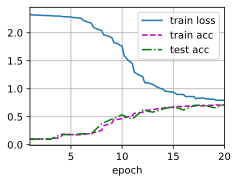

loss 0.792, train acc 0.710, test acc 0.716
1437.1 examples/sec on cuda:0


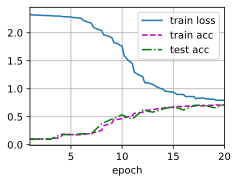

In [4]:
lr,num_epochs,batch_size=0.01,20,256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=224)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

## 7.3.4. 小结
- NiN架构无全连接层，使用由一个卷积层和多个1x1卷积层组成的块。该块可以在卷积神经网络中使用，以允许更多的每像素非线性。
- NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进行求和）。该汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。
- 移除全连接层可减少过拟合，同时显著减少NiN的参数。
- NiN架构无全连接层，交替使用NiN块和步幅为2的最大池化层（逐步减少高度和增大通道数），最后使用全局平均池化层得到输出（其输入通道数是类别数）。
- NiN的设计影响了许多后续卷积神经网络的设计。